# **1. Enquadre o problema e observe o panorama geral**
---
Este é o projeto final do curso de ML da UFSC, ensinado pelo professor Edson Júnior. Este trabalho foi baseado nas aulas e na bibliografia [principal](https://www.amazon.com.br/Hands-Machine-Learning-Scikit-Learn-TensorFlow-ebook/dp/B07XGF2G87). O dataset está disponível no [Kaggle](https://www.kaggle.com/datatattle/covid-19-nlp-text-classification/discussion/183471) e consiste em uma multiclassificação de tweets sobre o corona vírus. O objetivo deste projeto é classificar se o texto possui conteúdo neutro, positivo ou negativo sobre o assunto.  



## 1.1 - Configuração inicial




In [1]:
# Importar bibliotecas
import numpy as np
import os

In [2]:
# Para conseguir repetir o experimento
seed = 42
np.random.seed(seed)

In [3]:
# Para plotar figuras

%matplotlib inline 
import matplotlib as mpl 
import matplotlib.pyplot as plt 

mpl.rc('axes', labelsize=14) 
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [4]:
import warnings
warnings.filterwarnings('ignore')

# **2. Coletando os dados**
---


 Os arquivos no Kaggle são disponiblizados separadamente em conjunto de treino e teste. Enviamos eles para um [github](https://github.com/Joseane107/ML_course) e juntamos em um só arquivo. Os dados são público e podem ser utilizados para publicação com a devida referência.

In [5]:
# Pegando os arquivos no github
import requests

dataset_train = requests.get('https://raw.githubusercontent.com/Joseane107/ML_course/main/Corona_NLP_train.csv')
open("Corona_NLP_train.csv", "wt").write(dataset_train.text)

10487302

In [6]:
dataset_test = requests.get('https://raw.githubusercontent.com/Joseane107/ML_course/main/Corona_NLP_test.csv')
open('Corona_NLP_test.csv', "wt").write(dataset_test.text)

1000794

In [7]:
# Visualizando o primeiro arquivo
import pandas as pd
df_train = pd.read_csv('Corona_NLP_train.csv',encoding = 'ISO-8859-1')
df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [8]:
# Visualizando o segundo arquivo
df_test = pd.read_csv('Corona_NLP_test.csv', encoding='ISO-8859-1')
df_test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [9]:
# Reunindo os dois arquivos em um.
df = pd.concat([df_train,df_test],ignore_index=True)
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [10]:
# Visualizando 10 instâncias de forma aleatória.
df.sample(10, random_state=seed)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
33054,36853,81805,NaN,07-04-2020,https://t.co/2yMUPatIYU Wear a mask! Especiall...,Extremely Positive
33564,37363,82315,NaN,08-04-2020,"In light of Covid-19, Canada's insurers are re...",Positive
32707,36506,81458,5280,07-04-2020,@ate_ted @SenTedCruz Supply &amp; Demand. COVI...,Positive
13252,17051,62003,"Sydney, New South Wales",21-03-2020,Around 9 million people die of hunger and hung...,Extremely Negative
37837,41636,86588,India,11-04-2020,Alarming but informative video everyone should...,Extremely Positive
7974,11773,56725,"Dallas, TX",19-03-2020,Disruptions in the global #supplychain are bei...,Neutral
21882,25681,70633,Berlin,25-03-2020,"""#Alcohol won't solve your problems. Then agai...",Positive
31408,35207,80159,"Charlotte, NC",06-04-2020,See a full list of grocery stores in the #Char...,Neutral
26930,30729,75681,NY Metro Area,02-04-2020,'Stay at Home' Orders Are Stressing U.S. Famil...,Negative
12477,16276,61228,NaN,21-03-2020,Boris Johnson ordered the closure of the hospi...,Positive


Agora vamos verificar se não perdemos nenhuma instância no processo de união, verificando a quantidade delas em cada conjunto.

In [11]:
# Comprimento do primeiro conjunto
len(df_train)

41157

In [12]:
# Comprimento do segundo conjunto
len(df_test)

3798

In [13]:
# Comprimento do conjunto completo
len(df)

44955

Por questões de privacidade, os nomes dos usuários receberam códigos. Tais features não agregam nem na análise de dados nem na previsão das classes. Então vamos retirá-las do dataframe. 

In [14]:
# Retirando as colunas UserName e ScreenName.
df = df.drop(['UserName', 'ScreenName'], axis=1) 



In [15]:
df.head()

,Location,TweetAt,OriginalTweet,Sentiment
0,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


Neste momento, vamos diminuir o número de classes tendo em vista que uma classificação "extremamente positiva/negativa" pode ser relativa e redundante. Para isso, reunimos os comentários extremamente positivos na classe "positivo" e os comentários extremamente negativos na classe "negativo". 

In [16]:
# Deixando apenas as classes neutro, positivo e negativo.
import re
df['Sentiment'] = df['Sentiment'].apply( lambda x : ''.join(re.findall(r'Positive|Negative|Neutral',x)))

In [17]:
# Checando se deu certo.
df['Sentiment'].unique()

array(['Neutral', 'Positive', 'Negative'], dtype=object)

In [18]:
df.sample(10, random_state=seed)

,Location,TweetAt,OriginalTweet,Sentiment
33054,NaN,07-04-2020,https://t.co/2yMUPatIYU Wear a mask! Especiall...,Positive
33564,NaN,08-04-2020,"In light of Covid-19, Canada's insurers are re...",Positive
32707,5280,07-04-2020,@ate_ted @SenTedCruz Supply &amp; Demand. COVI...,Positive
13252,"Sydney, New South Wales",21-03-2020,Around 9 million people die of hunger and hung...,Negative
37837,India,11-04-2020,Alarming but informative video everyone should...,Positive
7974,"Dallas, TX",19-03-2020,Disruptions in the global #supplychain are bei...,Neutral
21882,Berlin,25-03-2020,"""#Alcohol won't solve your problems. Then agai...",Positive
31408,"Charlotte, NC",06-04-2020,See a full list of grocery stores in the #Char...,Neutral
26930,NY Metro Area,02-04-2020,'Stay at Home' Orders Are Stressing U.S. Famil...,Negative
12477,NaN,21-03-2020,Boris Johnson ordered the closure of the hospi...,Positive


In [19]:
# Número de instâncias permanece o mesmo.
df['Sentiment'].value_counts().values.sum()

44955

# 2.1 - Pré-precessamento dos dados

Necessário atribuir valores numéricos aos rótulos.

In [20]:
# Transformando os valores categóricos em numéricos.
df['Sentiment'] = df['Sentiment'].map({'Positive' : 0, 'Negative' : 1 , 'Neutral' : 2})

In [21]:
# Checando se deu certo.
df['Sentiment'].unique()

array([2, 0, 1])

In [22]:
df['Sentiment'].value_counts()

0    19592
1    17031
2     8332
Name: Sentiment, dtype: int64

# **3 Conjunto de treino e teste**
---

## 3.1 - Separando os conjuntos. 


In [23]:
# Vejamos quantas instâncias cada classe possui.
df['Sentiment'].value_counts()

0    19592
1    17031
2     8332
Name: Sentiment, dtype: int64

In [24]:
# Separando o conjunto de treino e teste de forma estratificada.
from sklearn.model_selection import train_test_split

train_set,test_set = train_test_split(df,stratify = df['Sentiment'] ,
                                      test_size = 0.30,shuffle = True , random_state = 42)

In [25]:
# Vemos que a proporção se mantém.
test_set['Sentiment'].value_counts()

0    5878
1    5109
2    2500
Name: Sentiment, dtype: int64

# **4. Explorando os dados**
---

## 4.1 - Dados faltantes

In [26]:
# Ver quantidade de dados faltantes.
train_set.isnull().sum()

Location         6640
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

Ao observarmos que a presença de dados faltantes se dá somente nas localizações, as quais não impactam de forma alguma na predição. Logo, não se faz necessário utilizar nenhuma técnica de imputação de dados.

## 4.2 - Análise das features


Todos os tweets foram realizados no ano de 2020. Então vamos criar uma nova feature 
apenas os com meses e realizar uma análise.

In [27]:
# Convertendo para tipo date.
train_set['TweetAt'] = pd.to_datetime(train_set['TweetAt'])

In [28]:
# Retirando apenas o mês.
train_set['Month'] = train_set['TweetAt'].dt.month

In [29]:
# Verificando se funcionou.
train_set.sample(25, random_state=seed)

,Location,TweetAt,OriginalTweet,Sentiment,Month
3632,"Austin, TX",2020-03-18,Cutting a business trip a short so as not to g...,0,3
5229,United States,2020-03-18,COVID-19 Retail Store Closures - WWD https://t...,2,3
43282,"Ohio, USA",2020-03-13,My grocery store. French's fried onions legit ...,2,3
25710,Edmonton Alberta #yeg,2020-01-04,"did a little shopping today, lineup at stupids...",1,1
5697,"Washington, DC",2020-03-19,everyone drop a food u panic bought bc of covi...,1,3
20072,NaN,2020-03-24,Buzzing #Stock: Jubilant Food suspends dine-in...,0,3
18113,In my own Utopia,2020-03-23,Businesses inflating prices amid this global p...,1,3
22223,"Cresskill, NJ",2020-03-25,.@NYGovCuomo has been a model governor through...,1,3
4246,"Dallas, TX",2020-03-18,https://t.co/ncczWKM76H\r\r\n#coronavirus #Cor...,0,3
37801,NaN,2020-11-04,WELLS FARGO Is it true that you are not provid...,0,11


Vemos no histograma abaixo que o maior número de tweets sobre o corona vírus ocorreram 
em março de 2020, com mais de 20000 textos. Nos outros meses, a quantidade 
de tweets se manteve abaixo de 2500.

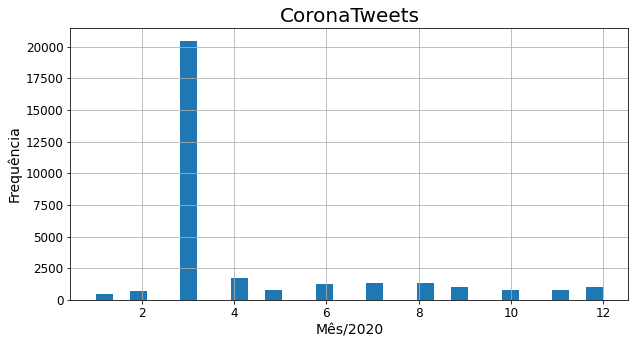

In [30]:
train_set['Month'].hist(bins=30, figsize=(10,5))
plt.title('CoronaTweets', fontsize=20)
plt.xlabel('Mês/2020')
plt.ylabel('Frequência')
plt.show()

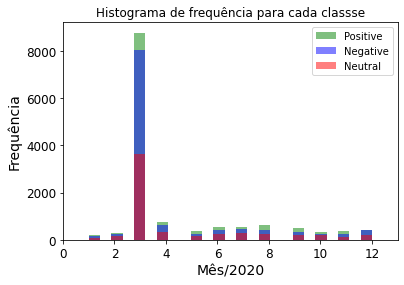

In [31]:
# Plot das três classes no mesmo histograma
x1 = train_set.loc[train_set.Sentiment==0, 'Month']
x2 = train_set.loc[train_set.Sentiment==1, 'Month']
x3 = train_set.loc[train_set.Sentiment==2, 'Month']

kwargs = dict(alpha=0.5, bins=25)

plt.hist(x1, **kwargs, color='g', label='Positive')
plt.hist(x2, **kwargs, color='b', label='Negative')
plt.hist(x3, **kwargs, color='r', label='Neutral')
plt.gca().set(title='Histograma de frequência para cada classse', ylabel='Frequência', xlabel='Mês/2020')
plt.xlim(0,13)
plt.legend();

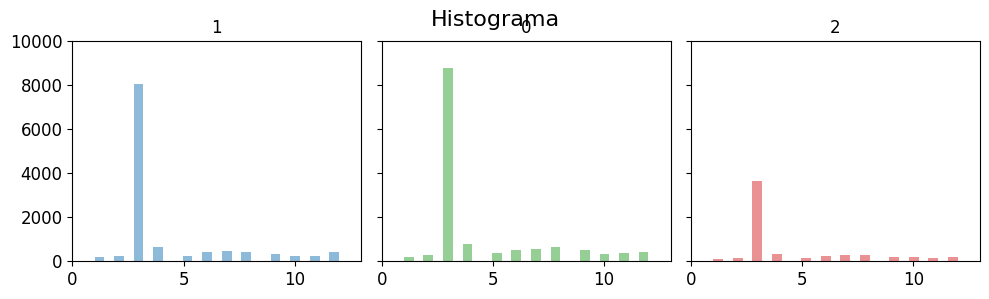

In [32]:
# Plot das três classes em histogramas distintos
fig, axes = plt.subplots(1, 3, figsize=(10,3), dpi=100, sharex=True, sharey=True)
colors = ['tab:blue', 'tab:green', 'tab:red']

for i, (ax, Sentiment) in enumerate(zip(axes.flatten(), train_set.Sentiment.unique())):
    x = train_set.loc[train_set.Sentiment==Sentiment, 'Month']
    ax.hist(x, alpha=0.5, bins=25, label=str(Sentiment), color=colors[i])
    ax.set_title(Sentiment)

plt.suptitle('Histograma', size=16)
ax.set_xlim(0, 13); ax.set_ylim(0, 10000);
plt.tight_layout();

Vemos nos histogramas acima que qualquer classe teve um aumento no mês de março, 
prevalecendo os comentários positivos e depois os negativos. Nos demais meses, a quantidade
de tweets positivos e negativos se mantiveram próximas e maior que a quantidade
de tweets neutros. 



## 4.2.1 Extraindo os países

In [ ]:
# Checando os dados.
train_set['Location'].sample(25)

3632                        Austin, TX
5229                     United States
43282                        Ohio, USA
25710            Edmonton Alberta #yeg
5697                    Washington, DC
20072                              NaN
18113                In my own Utopia 
22223                    Cresskill, NJ
4246                        Dallas, TX
37801                              NaN
9272                               NaN
30400                     Florence, OR
18255                 Ahmedabad, India
8519                        Tavarnuzze
20947                        Oxnard,CA
28968    Canada True North strong&free
19555                      mexico city
27868                 Cologne, Germany
10861                  Bromley, London
4969                   Sindh, Pakistan
38553                              NaN
6572                     San Diego, CA
30102                              NaN
40657                           London
36011                         Zimbabwe
Name: Location, dtype: ob

Ao analisarmos os dados referentes a classe das localizações fica evidente a existência de informações discrepantes, como é o caso de "In my own Utopia". Outro ponto relevante é a presença de cidades e países que representam o mesmo local. Por estes motivos utilizamos a biblioteca pycountry para remover o máximo de países que fosse possível.

In [ ]:
# Instalando a biblioteca pycountry.
!pip3 install pycountry
import pycountry

In [ ]:
# Criando a função para retirar os países.
def retrieve_country(x):
  try:
    country = pycountry.countries.search_fuzzy(x)[0].alpha_3
    return country
  except:
    return np.nan


In [ ]:
# Criando uma coluna com os países.
train_set['Country'] = train_set['Location'].apply( lambda x : retrieve_country(x))

In [ ]:
# Plotando o mapa.
import plotly.express as px
nao_nulos = df['Country'][df['Country'].notnull()]

fig = px.choropleth(
              locations = nao_nulos.value_counts().sort_values(ascending = False).index,
              color = nao_nulos.value_counts().sort_values(ascending = False).values,
              color_continuous_scale = 'Darkmint',
              labels = {'color' : 'Quantidade','locations' : 'Local'},
              title = 'Frequência dos tweets agrupados pelos países '
              )
                        
fig.show()

## 4.2.2 - Analisando as palavras

Uma wordcloud (nuvem de palavras) é um tipo de visualização em que seu tamanho é diretamente proporcional a sua frequência.

In [33]:
# Criando uma nuvem de palavras para os nossos dados.
from wordcloud import WordCloud,STOPWORDS

def create_wordcloud(df):

  texto = " ".join(palavra for palavra in df.values)
  stopwords = set(STOPWORDS)
  
  wordcloud = WordCloud(width=800, height=400,stopwords=stopwords,max_font_size=50, max_words=100,
                        background_color='black').generate(texto)
  
  plt.figure(figsize=(20,10))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.show()

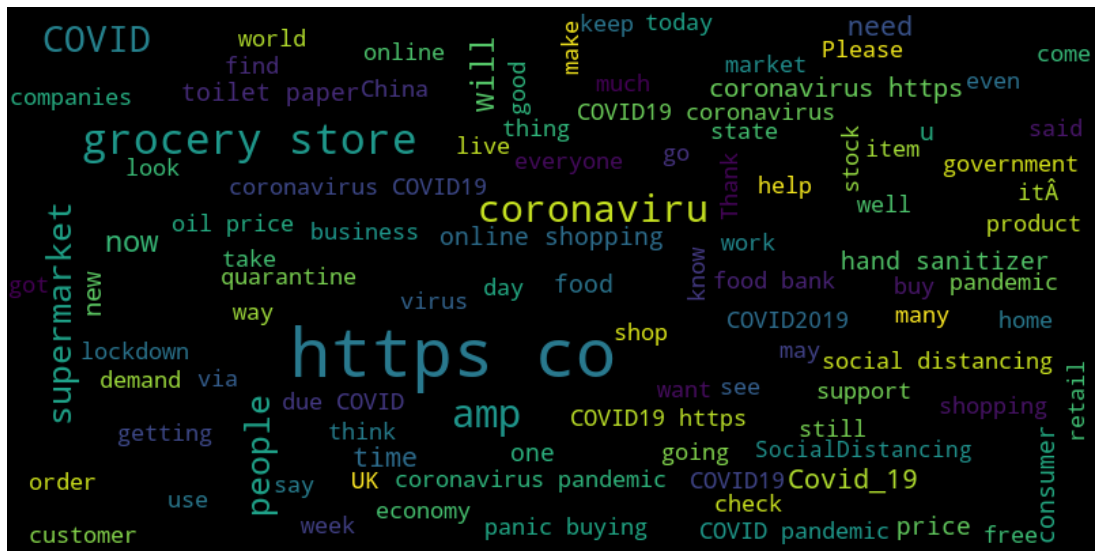

In [34]:
# Nuvem de palavras para todos os tweets.
create_wordcloud(train_set['OriginalTweet'])

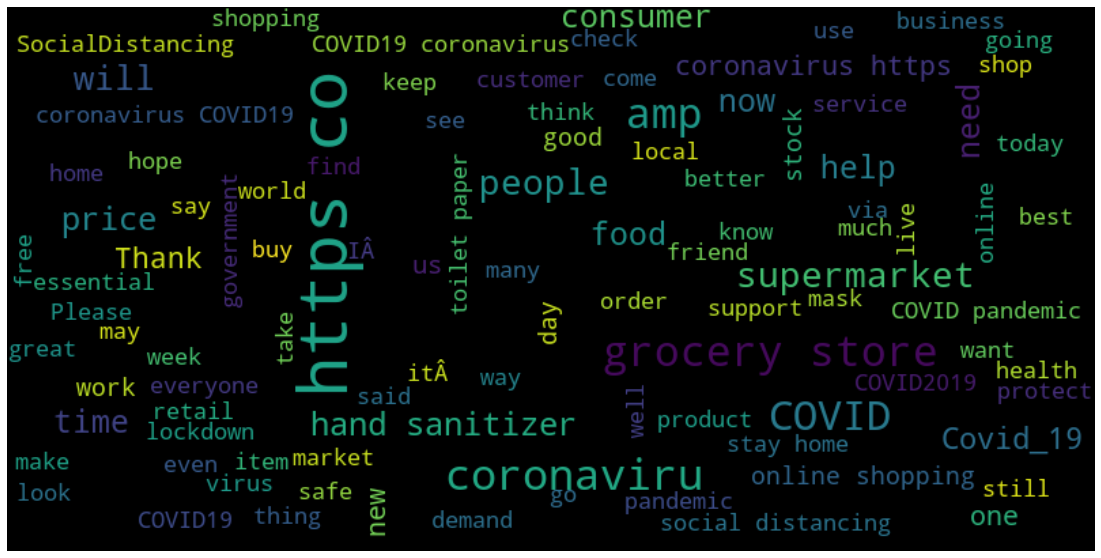

In [35]:
# Nuvem de palavras para todos os tweets positivos.
comentarios_positivos = train_set[train_set['Sentiment'] == 0]

create_wordcloud(comentarios_positivos['OriginalTweet'])

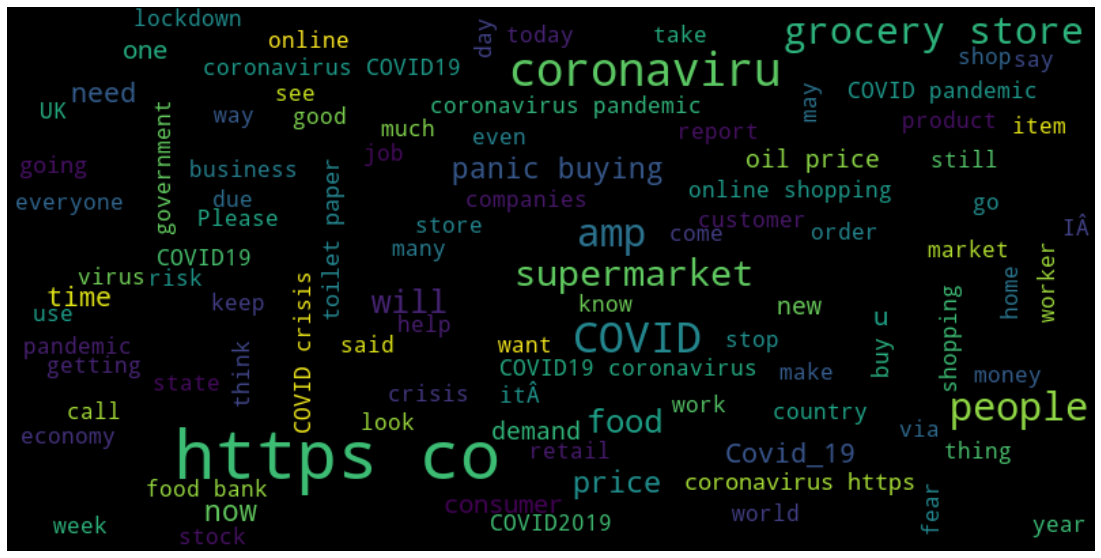

In [36]:
# Nuvem de palavras para todos os tweets negativos.
comentarios_negativos = train_set[train_set['Sentiment'] == 1]

create_wordcloud(comentarios_negativos['OriginalTweet'])

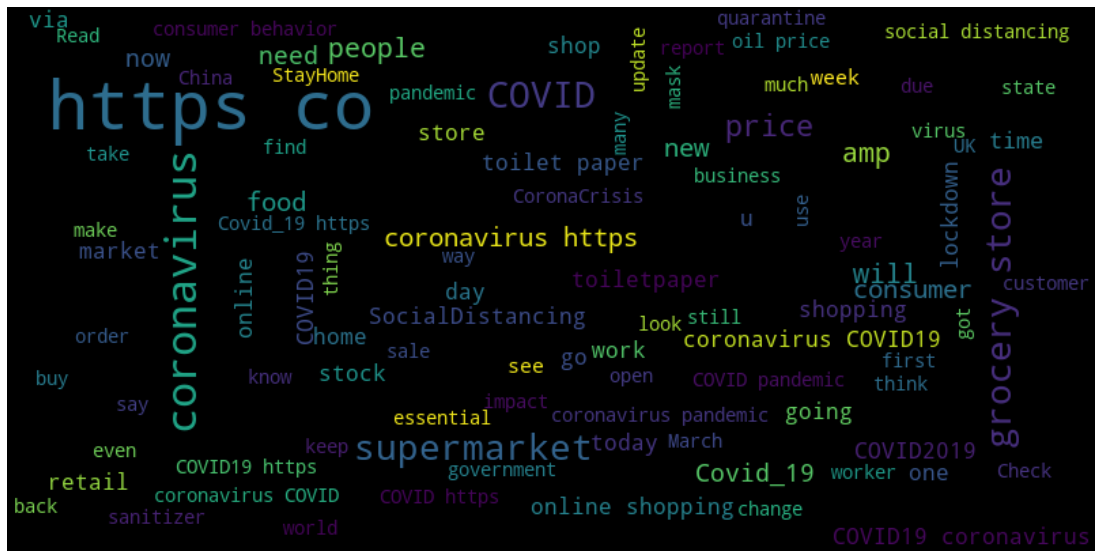

In [37]:
# Nuvem de palavras para todos os tweets neutros.
comentarios_neutros = train_set[train_set['Sentiment'] == 2]

create_wordcloud(comentarios_neutros['OriginalTweet'])

# **5. Treinando e avaliando modelos** 
---

## 5.1 - Bag of Words (BoW)

O BoW trata cada palavra de um texto separadamente e conta quantas vezes ela aparece. Além disso, a ordem em que as palavras aparecem não importam. Este processo inclui converter todas as strings para sua forma minúscula, remover a pontuação, tokenização e contar frequências. 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer

count_vector = CountVectorizer(strip_accents = 'unicode',lowercase= True,stop_words= 'english')

X = train_set['OriginalTweet'].copy()
y = train_set['Sentiment'].copy()

X_tr= count_vector.fit_transform(X)

X_tr.shape

A acurácia não é boa quando alguma classe é mais frequente do que outra. No nosso conjunto de treino, aproximadamente 43,58 % são tweets positivos, 37,89% são negativos e 18,53% são neutros. Vejamos a matriz de confusão.

In [ ]:
# Fazer predições em conjuntos no treino e não teste usando o predict.
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(LogisticRegression(), X_tr, y, cv=10)



Estamos mais interessados que os comentários negativos não sejam identificados como positivos ou neutros. Utilizando a regressão logística, a matriz de confusão nos diz que 12,11% dos comentários negativos foram identificados como positivo e 8,63% como neutro.

In [ ]:
from sklearn import metrics
print(metrics.confusion_matrix(y, y_pred))

Precisão : dos comentários preditos como positivo, 83% são identificados corretamente.

Recall : dos comentários realmente positivos, 82,5% são identificados corretamente.

In [ ]:
print(metrics.classification_report(y, y_pred, digits=3))

Observe abaixo o desempenho dos respectivos classificadores.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

y_pred = cross_val_predict(RandomForestClassifier(), X_tr,y,cv =10)

print(metrics.confusion_matrix(y, y_pred))


In [ ]:
print(metrics.classification_report(y, y_pred, digits=3))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_pred = cross_val_predict(KNeighborsClassifier(), X_tr,y,cv =10)

print(metrics.confusion_matrix(y, y_pred))


In [ ]:
print(metrics.classification_report(y, y_pred, digits=3))

In [ ]:
from sklearn.linear_model import SGDClassifier


y_pred = cross_val_predict(SGDClassifier(), X_tr,y,cv =10)

print(metrics.confusion_matrix(y, y_pred))



In [ ]:
print(metrics.classification_report(y, y_pred, digits=3))

In [ ]:
from sklearn.svm import LinearSVC

y_pred = cross_val_predict(LinearSVC(), X_tr,y,cv =10)

print(metrics.confusion_matrix(y, y_pred))

In [ ]:
print(metrics.classification_report(y, y_pred, digits=3))

Com os resultados obtidos, é possível afirmar que o modelo gradiente descendente estocástico (SDGC) obteve o melhor desempenho.

## 5.2 - Grid search

Agora vamos aprimorar os parâmetros do nosso modelo.

In [ ]:
from sklearn.model_selection import GridSearchCV

param = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], 
    'max_iter': [1000], 
    'loss': ['log',"hinge",'modified_huber'], 
    'penalty': ['l2'],
    'n_jobs': [-1]
}


grid = GridSearchCV(SGDClassifier(), param ,cv = 10)

grid.fit(X_tr,y)

In [ ]:
modelo =  grid.best_estimator_

# **6 - Avaliação**
---

In [ ]:
# Avaliando o modelo.
x_test = test_set['OriginalTweet'].copy()

y_test = test_set['Sentiment'].copy()

x_test_tr = count_vector.transform(x_test)



In [ ]:
modelo.fit(X_tr,y)

In [ ]:
pred = modelo.predict(x_test_tr)

print(metrics.confusion_matrix(y_test, pred))

print(metrics.classification_report(y_test, pred, digits=3))

Vemos que com os melhores parâmetros obtivemos uma maior precisão no modelo. Logo, o modelo está pronto para produção.

In [ ]:
# Convertendo para piclke.
import pickle

with open('model.pickle', 'wb') as f:
    pickle.dump(modelo, f)

# **7 - Conclusão**
---

Como o modelo já está apto para realizar o deploy, foi construído um Data App.